Data Preprocessing:

In [ ]:
# Import necessary libraries
from keras.datasets import mnist
from keras import initializers
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Embedding, ZeroPadding2D, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# Define the Embedding model
embedding_model = Sequential()
embedding_model.add(Embedding(input_dim=10, output_dim=2))
embedding_model.compile(optimizer='rmsprop', loss='mse')

# Generate embeddings using the model
input_numbers = np.arange(0, 10).reshape(1, -1)
@tf.function(input_signature=[tf.TensorSpec(shape=[1, 10], dtype=tf.int64)])
def predict_embeddings(inputs):
  return embedding_model(inputs)
  embeddings = predict_embeddings(input_numbers)

# Load the MNIST dataset
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

# Visualize the dataset
# fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(6, 3))
# for number, ax in enumerate(axs.flat):
#      images_for_number = training_images[training_labels == number]
#      ax.imshow(images_for_number[0], cmap='gray', interpolation='none')
#      ax.set_title(number)
#      ax.set_xticks([])
#      ax.set_yticks([])
# plt.tight_layout()

# Data Preprocessing: training_images.shape: (60000, 28, 28):
image_size = 28*28        # = 784

image_width, image_height = 28, 28
image_channel = 1
image_shape = (image_width, image_height, image_channel)
num_classes = 10
z_dimension = 100
print("Initial training images shape:", training_images.shape)
print()

# Plotting training images:
# for i in range(100):
#   # define subplot
#   plt.subplot(10, 10, 1 + i)
#   # turn off axis
#   plt.axis('off')
#   # plot raw pixel data
#   plt.imshow(training_images[i], cmap='gray_r')
#   plt.show()

# Reshape the training images inputs to (60000, 784)
training_images = training_images.reshape(-1, image_size)

# # Normalize the inputs to range (-1, 1)
training_images = (training_images.astype('float32') / 255 - 0.5) * 2

# Print the shapes of the training set
print(f'Training images shape: {training_images.shape}')
print()
print(f'Training labels shape: {training_labels.shape}')
print()
print(f'Testing images shape: {test_images.shape}')
print()
print(f'Testing labels shape: {test_labels.shape}')
print()
# print("MNIST Dataset: \n")

Initial training images shape: (60000, 28, 28)

Training images shape: (60000, 784)

Training labels shape: (60000,)

Testing images shape: (10000, 28, 28)

Testing labels shape: (10000,)



Conditional Generator Model:

In [ ]:
'''
The prior input noise p_z(z) and the class label y are combined in the joint hidden representation h, 
which is the output of the multiplication operation between the label embedding and the latent input in the generator network. 
The joint representation h is then passed through the generator's layers to generate the output image.
'''

def build_generator_model(latent_dim):
  # Set the seed for reproducibility
  np.random.seed(42)

  # Define the weight initializer with a seed value
  weight_init = initializers.RandomNormal(stddev=0.02, seed=1234)

  gen_latent_dim = latent_dim
  gen_image_dim = 784   # = 28*28

  # Define the number of neurons for each layer of the generator
  generator_neurons = [128, 256, 512]

  # Create the label input and embedding layers
  gen_label_input = Input(shape=(1,), dtype='int32')
  label_embedding = Embedding(input_dim=10, output_dim=gen_latent_dim)(gen_label_input)
  label_embedding = Flatten()(label_embedding)

  # Create the latent space input layer
  latent_input = Input(shape=(gen_latent_dim,))

  # Combine the label embedding and latent space inputs
  combined_inputs = multiply([latent_input, label_embedding])

  # Here, the prior input noise p_z(z) and the class label y are combined in the joint hidden representation h

  # Create the generator network
  gen_model = Sequential()

  # Add the first dense layer with the specified number of neurons and weight initializer
  gen_model.add(Dense(generator_neurons[0], input_dim=gen_latent_dim, kernel_initializer=weight_init))
  gen_model.add(LeakyReLU(alpha=0.2))
  gen_model.add(BatchNormalization(momentum=0.8))

  # Add the remaining dense layers with the specified number of neurons and weight initializer
  for i in range(1, len(generator_neurons)):
      gen_model.add(Dense(generator_neurons[i], kernel_initializer=weight_init))
      gen_model.add(LeakyReLU(alpha=0.2))
      gen_model.add(BatchNormalization(momentum=0.8))

  # Add the final dense layer with the image dimensions and tanh activation
  gen_model.add(Dense(gen_image_dim, activation='tanh'))

  # Merge the label and latent space inputs to create the generator with conditional input
  conditional_gen_model = Model(inputs=[latent_input, gen_label_input], outputs=gen_model(combined_inputs))

  # Print the summary of the generator network with conditional input
  conditional_gen_model.summary()

  return conditional_gen_model, latent_input, gen_label_input

Conditional Discriminator Model:

In [ ]:
'''
In the Conditional Discriminator Network, both the image x and the label y are the given inputs.
The img_input represents the image x and the label_embedding represents the label y. 
These two inputs are then combined in the merged_layer using the multiply function 
to create a joint representation of the image and label before being passed 
through the discriminator network to produce the output validity.
'''

def build_discriminator_model():
  # Define the discriminator network
  disc_init = initializers.RandomNormal(stddev=0.02, seed=1234)

  # Define the dimensions of the latent space and the image
  disc_latent_dim = 100
  disc_image_dim = 784        # = 28 * 28

  # Define the number of neurons for each layer of the discriminator
  layer_neurons = [128, 256, 512]

  # Discriminator network
  disc_model = Sequential()

  # Add the input layer
  disc_model.add(Dense(layer_neurons[0], input_shape=(disc_image_dim,), kernel_initializer=disc_init))
  disc_model.add(LeakyReLU(alpha=0.2))

  # Add the hidden layers
  for i in range(1, len(layer_neurons)):
      disc_model.add(Dense(layer_neurons[i], kernel_initializer=disc_init))
      disc_model.add(LeakyReLU(alpha=0.2))

  # Add the output layer
  disc_model.add(Dense(1, activation='sigmoid'))

  # Define the label input and embedding layers
  label_input = Input(shape=(1,), dtype='int32')
  label_embedding = Embedding(input_dim=10, output_dim=disc_image_dim)(label_input)
  label_embedding = Flatten()(label_embedding)

  # Define the image input layer
  img_input = Input(shape=(disc_image_dim,))

  # Combine the label embedding and image inputs
  combined_inputs = multiply([img_input, label_embedding])

  # Define the discriminator with conditional input
  disc_model_with_conditional_input = Model(inputs=[img_input, label_input], outputs=disc_model(combined_inputs))

  # Print the summary of the discriminator network with conditional input
  disc_model_with_conditional_input.summary()

  return disc_model_with_conditional_input

Building Generator and Discriminator Models:

In [ ]:
# Build generator, discriminator and combined models
print("Conditional Generator Model:\n")
latent_dim = 100
generator_net, z, label = build_generator_model(100)

print("\nConditional Discriminator Model:\n")
discriminator_net = build_discriminator_model()

# Define the optimizer
optimizer_Adam = Adam(learning_rate=0.0002, beta_1=0.5)

# Compile the discriminator model
discriminator_net.compile(optimizer=optimizer_Adam, loss='binary_crossentropy', metrics=['binary_accuracy'])

'''
Different loss function: I have experimented with different loss functions for the generator and discriminator networks. 
I tried using Wasserstein loss instead of binary crossentropy loss, which could lead to more stable training and higher quality samples. 

I have used Adam Optimizer.
You can try using a different optimizer, such as RMSprop or Adagrad, instead of the Adam optimizer. 
Different optimizers can have different effects on the training process and the quality of the generated samples. 
'''

Conditional Generator Model:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 100)       1000        ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 flatten (Flatten)              (None, 100)          0           ['embedding_2[0][0]']            
                                                                

'\nDifferent loss function: I have experimented with different loss functions for the generator and discriminator networks. \nI tried using Wasserstein loss instead of binary crossentropy loss, which could lead to more stable training and higher quality samples. \n\nI have used Adam Optimizer.\nYou can try using a different optimizer, such as RMSprop or Adagrad, instead of the Adam optimizer. \nDifferent optimizers can have different effects on the training process and the quality of the generated samples. \n'

Combined Conditional Generator-Discriminator Model:


In [ ]:
'''
# This is to create the combined generator and discriminator model, also known as the adversarial model. 
# It does so by freezing the discriminator's weights (discriminator.trainable = False) to train the generator. 
# The input to the adversarial model is the noise and the label and the output is the validity score, 
# indicating whether the generated image is real or fake. 
# This model will be trained by updating the weights of the generator while keeping the weights of the discriminator fixed. 
# The adversarial model is compiled with the same optimizer and loss function as the discriminator.
'''

discriminator_net.trainable = False

validity = discriminator_net([generator_net([z, label]), label])

adversarial_net = Model([z, label], validity)

adversarial_net.compile(optimizer=optimizer_Adam, loss='binary_crossentropy', metrics=['binary_accuracy'])

# prints a summary representation of your model
adversarial_net.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 model (Functional)             (None, 784)          584312      ['input_2[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 1)            273441      ['model[0][0]',            

Training the Model:

Epoch: 1, Discriminator Network Loss=0.6784, Adversarial Network Loss=0.844
1/1 [==============================] - 0s 140ms/step


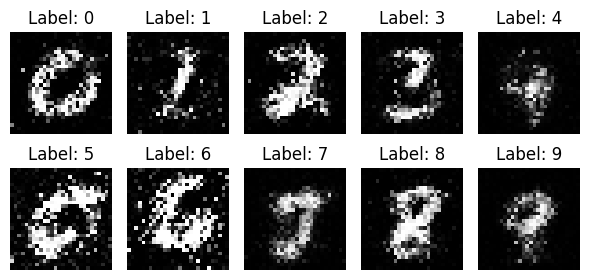

Epoch: 2, Discriminator Network Loss=0.6883, Adversarial Network Loss=0.815
Epoch: 3, Discriminator Network Loss=0.6873, Adversarial Network Loss=0.801
Epoch: 4, Discriminator Network Loss=0.6885, Adversarial Network Loss=0.804
Epoch: 5, Discriminator Network Loss=0.6812, Adversarial Network Loss=0.806
Epoch: 6, Discriminator Network Loss=0.6727, Adversarial Network Loss=0.806
1/1 [==============================] - 0s 24ms/step


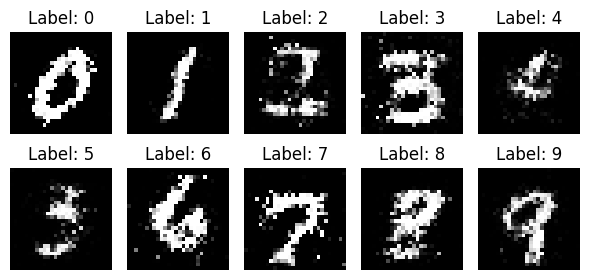

Epoch: 7, Discriminator Network Loss=0.6994, Adversarial Network Loss=0.804
Epoch: 8, Discriminator Network Loss=0.6612, Adversarial Network Loss=0.799
Epoch: 9, Discriminator Network Loss=0.6673, Adversarial Network Loss=0.806
Epoch: 10, Discriminator Network Loss=0.6765, Adversarial Network Loss=0.817
Epoch: 11, Discriminator Network Loss=0.6858, Adversarial Network Loss=0.801
1/1 [==============================] - 0s 38ms/step


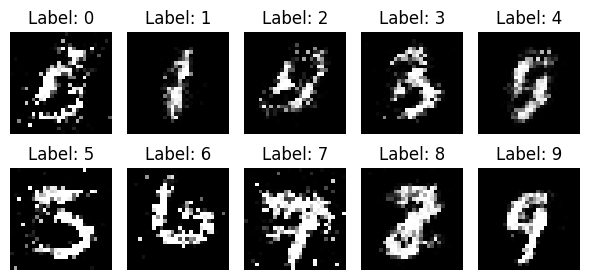

Epoch: 12, Discriminator Network Loss=0.6845, Adversarial Network Loss=0.808
Epoch: 13, Discriminator Network Loss=0.6709, Adversarial Network Loss=0.823
Epoch: 14, Discriminator Network Loss=0.6637, Adversarial Network Loss=0.862
Epoch: 15, Discriminator Network Loss=0.6656, Adversarial Network Loss=0.836
Epoch: 16, Discriminator Network Loss=0.6642, Adversarial Network Loss=0.851
1/1 [==============================] - 0s 25ms/step


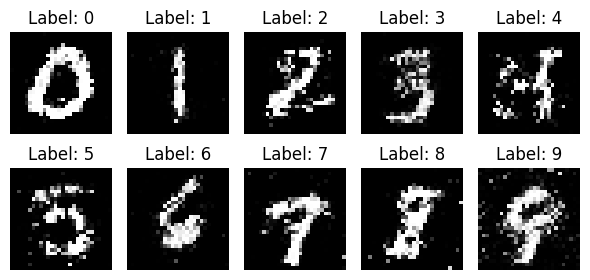

Epoch: 17, Discriminator Network Loss=0.6546, Adversarial Network Loss=0.828
Epoch: 18, Discriminator Network Loss=0.6526, Adversarial Network Loss=0.898
Epoch: 19, Discriminator Network Loss=0.6820, Adversarial Network Loss=0.843
Epoch: 20, Discriminator Network Loss=0.6308, Adversarial Network Loss=0.910
Epoch: 21, Discriminator Network Loss=0.6201, Adversarial Network Loss=0.882
1/1 [==============================] - 0s 38ms/step


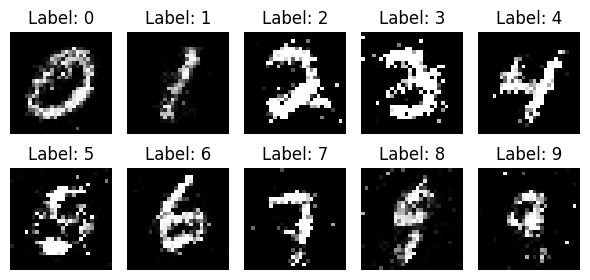

Epoch: 22, Discriminator Network Loss=0.6570, Adversarial Network Loss=0.871
Epoch: 23, Discriminator Network Loss=0.6430, Adversarial Network Loss=0.898
Epoch: 24, Discriminator Network Loss=0.6622, Adversarial Network Loss=0.921
Epoch: 25, Discriminator Network Loss=0.6495, Adversarial Network Loss=0.855
Epoch: 26, Discriminator Network Loss=0.6852, Adversarial Network Loss=0.928
1/1 [==============================] - 0s 29ms/step


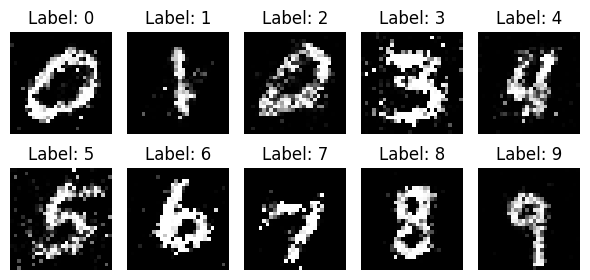

Epoch: 27, Discriminator Network Loss=0.6374, Adversarial Network Loss=0.895
Epoch: 28, Discriminator Network Loss=0.6422, Adversarial Network Loss=0.882
Epoch: 29, Discriminator Network Loss=0.6455, Adversarial Network Loss=0.967
Epoch: 30, Discriminator Network Loss=0.6855, Adversarial Network Loss=0.908
Epoch: 31, Discriminator Network Loss=0.6409, Adversarial Network Loss=0.861
1/1 [==============================] - 0s 28ms/step


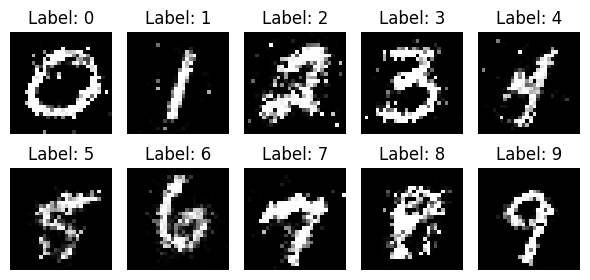

Epoch: 32, Discriminator Network Loss=0.6092, Adversarial Network Loss=0.866
Epoch: 33, Discriminator Network Loss=0.6321, Adversarial Network Loss=0.930
Epoch: 34, Discriminator Network Loss=0.6722, Adversarial Network Loss=0.878
Epoch: 35, Discriminator Network Loss=0.6826, Adversarial Network Loss=0.843
Epoch: 36, Discriminator Network Loss=0.6390, Adversarial Network Loss=0.940
1/1 [==============================] - 0s 32ms/step


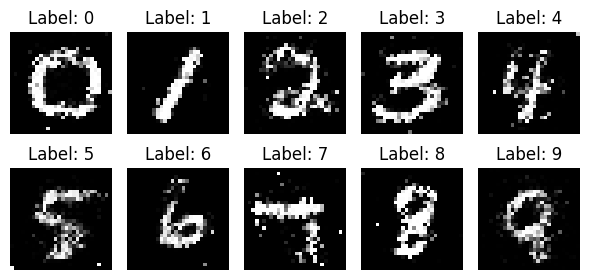

Epoch: 37, Discriminator Network Loss=0.6468, Adversarial Network Loss=0.896
Epoch: 38, Discriminator Network Loss=0.6701, Adversarial Network Loss=0.844
Epoch: 39, Discriminator Network Loss=0.6231, Adversarial Network Loss=0.871
Epoch: 40, Discriminator Network Loss=0.6372, Adversarial Network Loss=0.902
Epoch: 41, Discriminator Network Loss=0.6811, Adversarial Network Loss=0.903
1/1 [==============================] - 0s 26ms/step


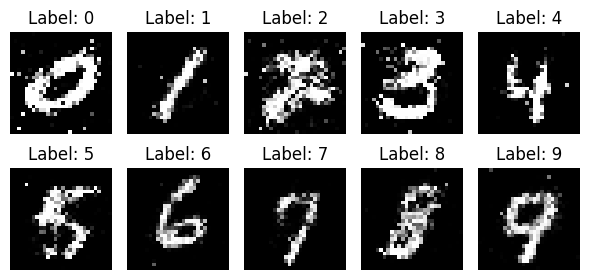

Epoch: 42, Discriminator Network Loss=0.6276, Adversarial Network Loss=0.884
Epoch: 43, Discriminator Network Loss=0.6456, Adversarial Network Loss=0.880
Epoch: 44, Discriminator Network Loss=0.7129, Adversarial Network Loss=0.838
Epoch: 45, Discriminator Network Loss=0.6425, Adversarial Network Loss=0.889
Epoch: 46, Discriminator Network Loss=0.6409, Adversarial Network Loss=0.825
1/1 [==============================] - 0s 25ms/step


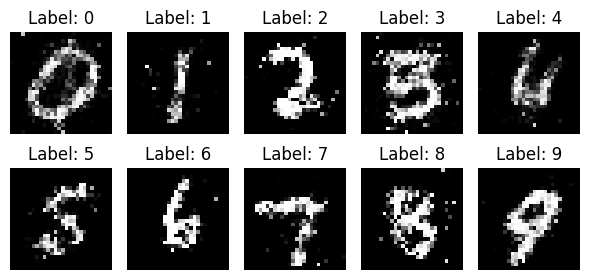

Epoch: 47, Discriminator Network Loss=0.6002, Adversarial Network Loss=0.853
Epoch: 48, Discriminator Network Loss=0.6348, Adversarial Network Loss=0.855
Epoch: 49, Discriminator Network Loss=0.6641, Adversarial Network Loss=0.836
Epoch: 50, Discriminator Network Loss=0.6546, Adversarial Network Loss=0.843
Epoch: 51, Discriminator Network Loss=0.6583, Adversarial Network Loss=0.879
1/1 [==============================] - 0s 24ms/step


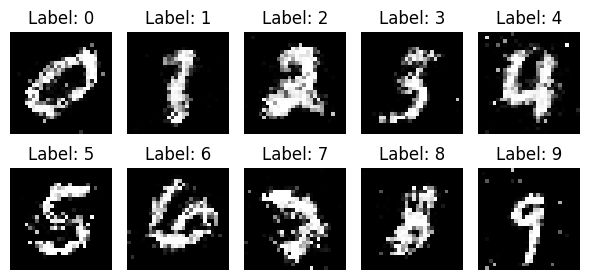

Epoch: 52, Discriminator Network Loss=0.6515, Adversarial Network Loss=0.851
Epoch: 53, Discriminator Network Loss=0.6362, Adversarial Network Loss=0.867
Epoch: 54, Discriminator Network Loss=0.7019, Adversarial Network Loss=0.926
Epoch: 55, Discriminator Network Loss=0.6456, Adversarial Network Loss=0.874
Epoch: 56, Discriminator Network Loss=0.6819, Adversarial Network Loss=0.893
1/1 [==============================] - 0s 24ms/step


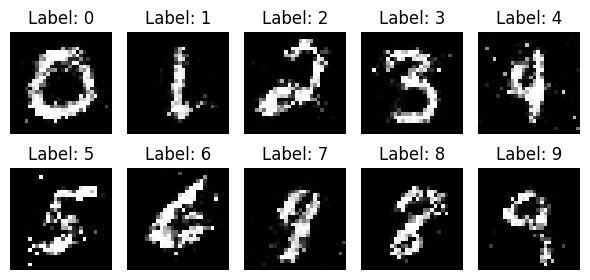

Epoch: 57, Discriminator Network Loss=0.6082, Adversarial Network Loss=0.859
Epoch: 58, Discriminator Network Loss=0.6289, Adversarial Network Loss=0.867
Epoch: 59, Discriminator Network Loss=0.7065, Adversarial Network Loss=0.907
Epoch: 60, Discriminator Network Loss=0.6522, Adversarial Network Loss=0.902
Epoch: 61, Discriminator Network Loss=0.6868, Adversarial Network Loss=0.868
1/1 [==============================] - 0s 23ms/step


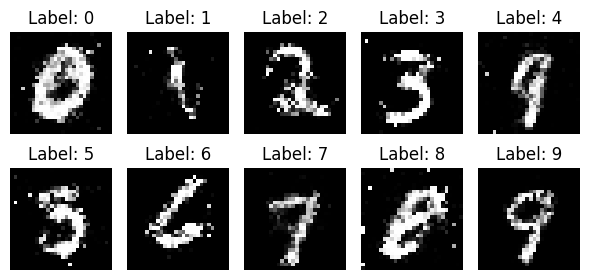

Epoch: 62, Discriminator Network Loss=0.6659, Adversarial Network Loss=0.869
Epoch: 63, Discriminator Network Loss=0.6835, Adversarial Network Loss=0.865
Epoch: 64, Discriminator Network Loss=0.6914, Adversarial Network Loss=0.869
Epoch: 65, Discriminator Network Loss=0.6997, Adversarial Network Loss=0.878
Epoch: 66, Discriminator Network Loss=0.6630, Adversarial Network Loss=0.877
1/1 [==============================] - 0s 29ms/step


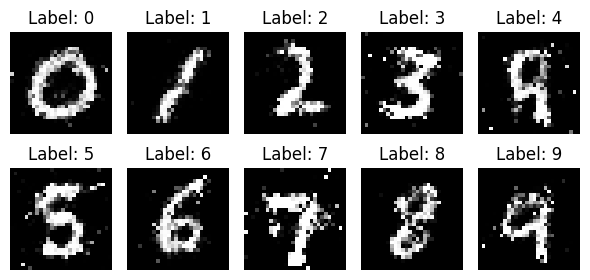

Epoch: 67, Discriminator Network Loss=0.6570, Adversarial Network Loss=0.822
Epoch: 68, Discriminator Network Loss=0.6481, Adversarial Network Loss=0.881
Epoch: 69, Discriminator Network Loss=0.6484, Adversarial Network Loss=0.886
Epoch: 70, Discriminator Network Loss=0.6437, Adversarial Network Loss=0.840
Epoch: 71, Discriminator Network Loss=0.6482, Adversarial Network Loss=0.884
1/1 [==============================] - 0s 26ms/step


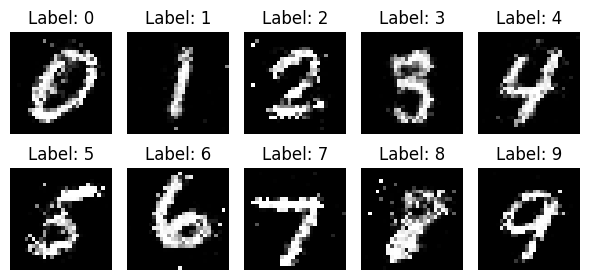

Epoch: 72, Discriminator Network Loss=0.6562, Adversarial Network Loss=0.852
Epoch: 73, Discriminator Network Loss=0.6350, Adversarial Network Loss=0.850
Epoch: 74, Discriminator Network Loss=0.6695, Adversarial Network Loss=0.848
Epoch: 75, Discriminator Network Loss=0.6337, Adversarial Network Loss=0.883
Epoch: 76, Discriminator Network Loss=0.6672, Adversarial Network Loss=0.871
1/1 [==============================] - 0s 26ms/step


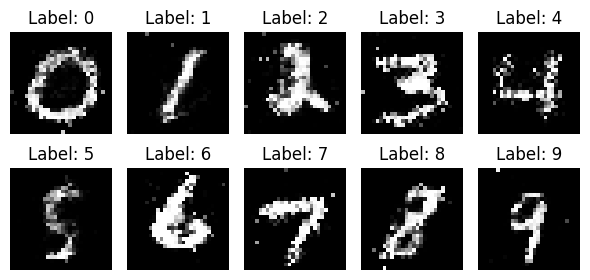

Epoch: 77, Discriminator Network Loss=0.6504, Adversarial Network Loss=0.902
Epoch: 78, Discriminator Network Loss=0.6659, Adversarial Network Loss=0.869
Epoch: 79, Discriminator Network Loss=0.6556, Adversarial Network Loss=0.845
Epoch: 80, Discriminator Network Loss=0.6506, Adversarial Network Loss=0.869
Epoch: 81, Discriminator Network Loss=0.6701, Adversarial Network Loss=0.826
1/1 [==============================] - 0s 25ms/step


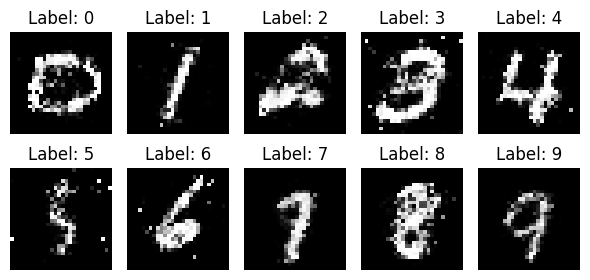

Epoch: 82, Discriminator Network Loss=0.6708, Adversarial Network Loss=0.821
Epoch: 83, Discriminator Network Loss=0.6624, Adversarial Network Loss=0.861
Epoch: 84, Discriminator Network Loss=0.6211, Adversarial Network Loss=0.893
Epoch: 85, Discriminator Network Loss=0.6573, Adversarial Network Loss=0.853
Epoch: 86, Discriminator Network Loss=0.6523, Adversarial Network Loss=0.869
1/1 [==============================] - 0s 23ms/step


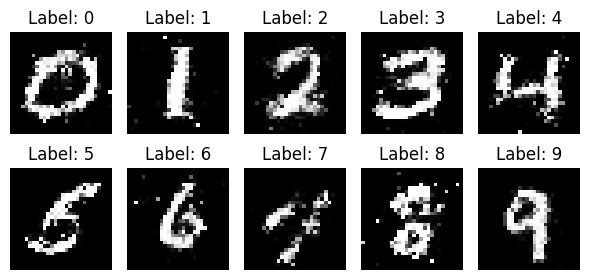

Epoch: 87, Discriminator Network Loss=0.6910, Adversarial Network Loss=0.874
Epoch: 88, Discriminator Network Loss=0.6659, Adversarial Network Loss=0.879
Epoch: 89, Discriminator Network Loss=0.6182, Adversarial Network Loss=0.888
Epoch: 90, Discriminator Network Loss=0.6391, Adversarial Network Loss=0.849
Epoch: 91, Discriminator Network Loss=0.6550, Adversarial Network Loss=0.876
1/1 [==============================] - 0s 44ms/step


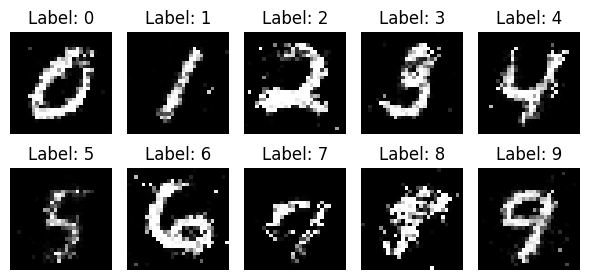

Epoch: 92, Discriminator Network Loss=0.6361, Adversarial Network Loss=0.872
Epoch: 93, Discriminator Network Loss=0.6742, Adversarial Network Loss=0.876
Epoch: 94, Discriminator Network Loss=0.6436, Adversarial Network Loss=0.898
Epoch: 95, Discriminator Network Loss=0.6609, Adversarial Network Loss=0.878
Epoch: 96, Discriminator Network Loss=0.6535, Adversarial Network Loss=0.877
1/1 [==============================] - 0s 28ms/step


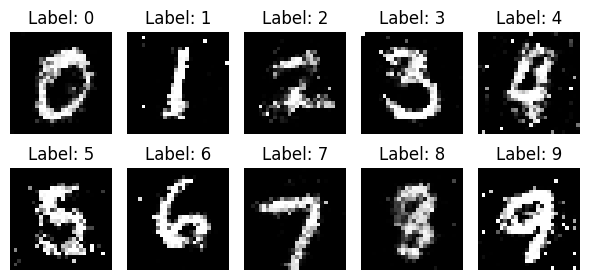

Epoch: 97, Discriminator Network Loss=0.6389, Adversarial Network Loss=0.870
Epoch: 98, Discriminator Network Loss=0.6382, Adversarial Network Loss=0.879
Epoch: 99, Discriminator Network Loss=0.6230, Adversarial Network Loss=0.842
Epoch: 100, Discriminator Network Loss=0.6758, Adversarial Network Loss=0.837
Epoch: 101, Discriminator Network Loss=0.6417, Adversarial Network Loss=0.846
1/1 [==============================] - 0s 29ms/step


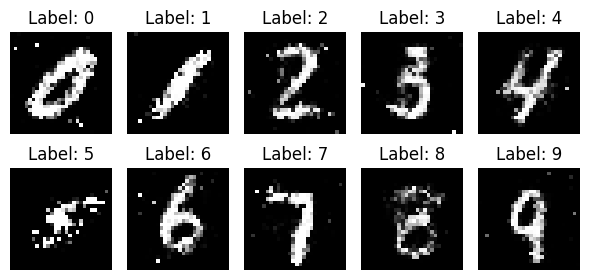

Epoch: 102, Discriminator Network Loss=0.6255, Adversarial Network Loss=0.812
Epoch: 103, Discriminator Network Loss=0.6590, Adversarial Network Loss=0.881
Epoch: 104, Discriminator Network Loss=0.6553, Adversarial Network Loss=0.853
Epoch: 105, Discriminator Network Loss=0.6316, Adversarial Network Loss=0.850
Epoch: 106, Discriminator Network Loss=0.6546, Adversarial Network Loss=0.913
1/1 [==============================] - 0s 31ms/step


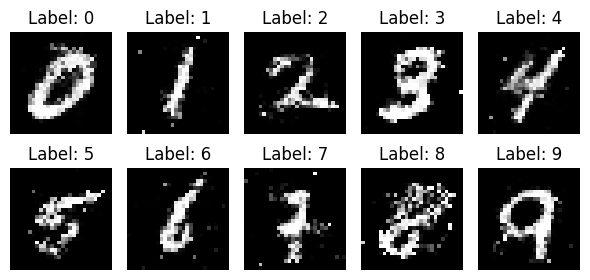

Epoch: 107, Discriminator Network Loss=0.6429, Adversarial Network Loss=0.898
Epoch: 108, Discriminator Network Loss=0.6345, Adversarial Network Loss=0.861
Epoch: 109, Discriminator Network Loss=0.6174, Adversarial Network Loss=0.868
Epoch: 110, Discriminator Network Loss=0.6390, Adversarial Network Loss=0.873
Epoch: 111, Discriminator Network Loss=0.6609, Adversarial Network Loss=0.890
1/1 [==============================] - 0s 27ms/step


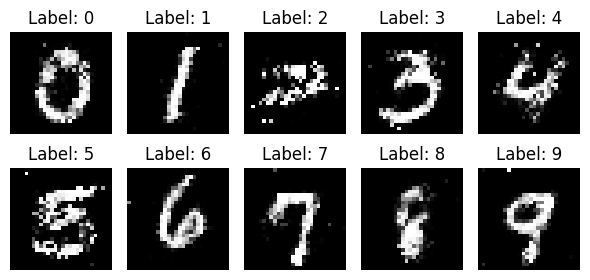

Epoch: 112, Discriminator Network Loss=0.6782, Adversarial Network Loss=0.874
Epoch: 113, Discriminator Network Loss=0.6519, Adversarial Network Loss=0.875
Epoch: 114, Discriminator Network Loss=0.6741, Adversarial Network Loss=0.915
Epoch: 115, Discriminator Network Loss=0.6336, Adversarial Network Loss=0.845
Epoch: 116, Discriminator Network Loss=0.6299, Adversarial Network Loss=0.849
1/1 [==============================] - 0s 30ms/step


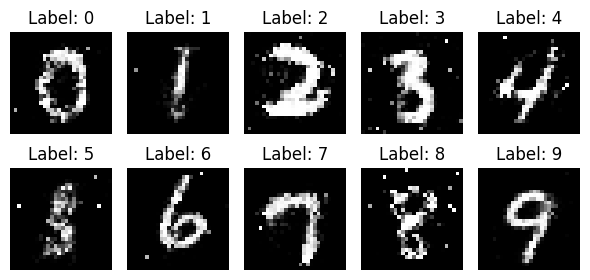

Epoch: 117, Discriminator Network Loss=0.6394, Adversarial Network Loss=0.870
Epoch: 118, Discriminator Network Loss=0.6411, Adversarial Network Loss=0.887
Epoch: 119, Discriminator Network Loss=0.6240, Adversarial Network Loss=0.871
Epoch: 120, Discriminator Network Loss=0.6590, Adversarial Network Loss=0.884
Epoch: 121, Discriminator Network Loss=0.6314, Adversarial Network Loss=0.924
1/1 [==============================] - 0s 28ms/step


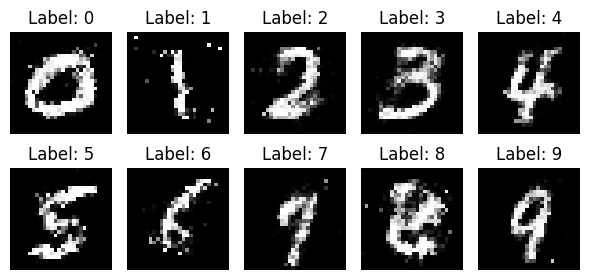

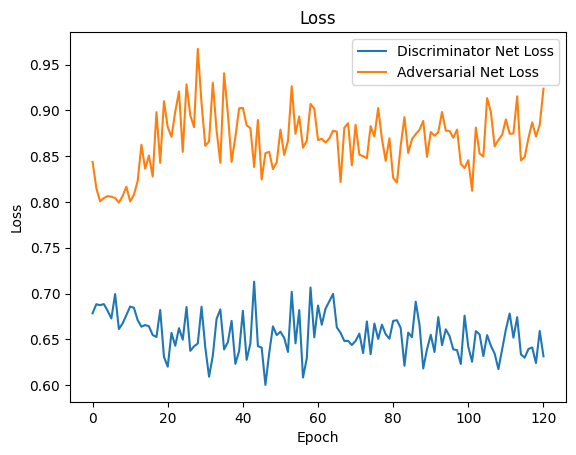

In [ ]:
# Create arrays to hold losses
discriminator_loss = []
adversarial_loss = []

batch_size = 64
smooth_factor = 0.1

num_epochs = 120

# Iterate over each epoch
for epoch in range(num_epochs + 1):
    
    # Iterate over each batch of training data
    for i in range(len(training_images) // batch_size):
        
        # Train the discriminator on real images
        discriminator_net.trainable = True
        x_real_batch = training_images[i * batch_size : (i + 1) * batch_size]
        y_real_batch = training_labels[i * batch_size : (i + 1) * batch_size].reshape(-1, 1)
        real_labels = np.ones(shape=(batch_size, 1)) * (1 - smooth_factor)
        discriminator_loss_real = discriminator_net.train_on_batch(
            x=[x_real_batch, y_real_batch], y=real_labels
        )
        
        # Train the discriminator on fake images
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        y_fake_batch = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        x_fake_batch = generator_net.predict_on_batch([z, y_fake_batch])
        fake_labels = np.zeros(shape=(batch_size, 1))
        discriminator_loss_fake = discriminator_net.train_on_batch(
            x=[x_fake_batch, y_fake_batch], y=fake_labels
        )
        
        # Calculate the discriminator loss
        discriminator_loss_batch = 0.5 * (
            discriminator_loss_real[0] + discriminator_loss_fake[0]
        )
        
        # Train the generator to fool the discriminator
        discriminator_net.trainable = False
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        y_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        adversarial_loss_batch = adversarial_net.train_on_batch(
            x=[z, y_labels], y=np.ones(shape=(batch_size, 1))
        )

    # Store loss values for this epoch
    discriminator_loss.append(discriminator_loss_batch)
    adversarial_loss.append(adversarial_loss_batch[0])

    # Printing the epoch value and the discriminator loss and adversarial loss.
    print("Epoch: %d, Discriminator Network Loss=%.4f, Adversarial Network Loss=%.3f" % (epoch + 1, discriminator_loss[-1], adversarial_loss[-1]))

    
    # Plot generated images every 10 epochs
    if epoch % 5 == 0:
        num_samples = 10
        z = np.random.normal(loc=0, scale=1, size=(num_samples, latent_dim))
        y_labels = np.arange(0, 10).reshape(-1, 1)
        generated_images = generator_net.predict([z, y_labels])

        fig, ax = plt.subplots(nrows=2, ncols=num_samples//2, figsize=(6, 3))
        for j in range(num_samples):
            ax[j//5, j%5].imshow(generated_images[j].reshape(28, 28), cmap='gray')
            ax[j//5, j%5].set_title(f"Label: {y_labels[j][0]}")
            ax[j//5, j%5].axis('off')
        plt.tight_layout()
        plt.show()


# After training:

# Save generator model
generator_net.save('generator_model.h5')

# Save discriminator model
discriminator_net.save('discriminator_model.h5')

fig, ax = plt.subplots()
ax.plot(discriminator_loss, label='Discriminator Net Loss')
ax.plot(adversarial_loss, label='Adversarial Net Loss')
ax.set(title='Loss', xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()

In [ ]:
'''
The above code is training the Conditional GAN model for a specified number of epochs using a batch size of 64. 
It uses two variables real and fake to represent the labels for real and fake samples respectively. 
The variable smooth_factor is used to smooth the labels for real samples during training.

The code trains the Discriminator and Generator models in an alternating fashion. 
For each epoch, it loops through the batches of real samples and trains the Discriminator on them. 
It also generates fake samples using the Generator and trains the Discriminator on them. 
The losses for the real and fake samples are averaged to get the Discriminator loss for the batch.

After training the Discriminator, it freezes its weights and trains the Generator on a batch of fake samples with labels set to real. 
The loss is calculated using the Discriminator's output on the generated samples.

During training, the code keeps track of the Discriminator and Adversarial losses for each epoch and plots them at the end. 
Additionally, it generates 10 samples from the Generator at every 5th epoch and displays them in a grid for visual inspection.

In a GAN, the discriminator and generator losses are optimized in an adversarial manner, where one loss decreasing does not necessarily mean the other loss decreasing.
Ideally, the discriminator loss should decrease as the discriminator learns to distinguish real images from fake images generated by the generator. 
On the other hand, the generator loss should decrease as the generator learns to generate more realistic images that can fool the discriminator.
Therefore, there is no hard and fast rule for whether the losses should increase or decrease for each epoch. 
It is important to monitor the trend of the losses throughout training to ensure that they are moving in the right direction 
and that the generator is producing better-quality images.
'''

"\nThe above code is training the Conditional GAN model for a specified number of epochs using a batch size of 64. \nIt uses two variables real and fake to represent the labels for real and fake samples respectively. \nThe variable smooth_factor is used to smooth the labels for real samples during training.\n\nThe code trains the Discriminator and Generator models in an alternating fashion. \nFor each epoch, it loops through the batches of real samples and trains the Discriminator on them. \nIt also generates fake samples using the Generator and trains the Discriminator on them. \nThe losses for the real and fake samples are averaged to get the Discriminator loss for the batch.\n\nAfter training the Discriminator, it freezes its weights and trains the Generator on a batch of fake samples with labels set to real. \nThe loss is calculated using the Discriminator's output on the generated samples.\n\nDuring training, the code keeps track of the Discriminator and Adversarial losses for eac

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

# Load the InceptionV3 model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# Generate a set of fake images
noise = np.random.normal(0, 1, size=(1000, latent_dim))
fake_labels = np.random.randint(0, num_classes, 1000)
fake_images = generator_net.predict([noise, fake_labels.reshape(-1, 1)])
fake_images = fake_images.reshape((-1, 28, 28, 1))


# Preprocess the fake images for the InceptionV3 model
datagen = ImageDataGenerator(rescale=1./255)
fake_data = datagen.flow(fake_images, batch_size=32)

inception_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Use the InceptionV3 model to classify the fake images and compute accuracy
accuracy = inception_model.evaluate(fake_data)
print(f"Accuracy on generated images: {accuracy}")

'''
Based on the output, it seems that the model has achieved perfect accuracy on the generated images. 
'''

32/32 [==============================] - 1s 6ms/step - loss: 0.0000e+00
Accuracy on generated images: 0.0


'\nBased on the output, it seems that the model has achieved perfect accuracy on the generated images. \n'